Time Series Forecasting to Predict Bitcoin Prices

In this notebook, I will be experimenting with two types of RNN architecture. One will be DeepAR, which is a custom RNN network created by AWS. It was also covered in Udacity Machne Learning Engineer Nanodegree. The main RNN architecture will be LSTM. We will experiment with different combination of hidden layers and epoch. Finally the MSE of both of these models will be compared to the results in the benchmark GRU model presented in the paper entitled "A Gated Recurrent Unit Approach to Bitcoin Price Prediction."

The Machine Learning workflow that we will be using will be:
1)Loading and exploring the data
2)Creating training, validation and test sets of time series
3)For DeepAR,we will format the csv to JSON
4)Instantiating and training the DeepAR estimator
5)Deploying the DeepAR model and creaing its predictor
6)Evaluating the predictor for DeepAR
7)Instantiating and training the LSTM estimator
8)Deploying the LSTM model and creaing its predictor
9)Evaluating the predictor for LSTM
10)Comparing the MSE and accuracies for DeepAR v LSTM v GRU 

In [39]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd


data = pd.read_csv('./data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv')
data.isnull().values.any()

True

In [40]:
data.head(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1325318220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1325318280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1325318340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1325318400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1325318460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
from datetime import datetime
data.dropna(subset = ["Weighted_Price"], inplace=True)
data.reset_index(drop=True, inplace=True) ##Too many null values so wanted to drop it and reindex


data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date
data.drop(['Timestamp'], axis=1)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
1,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
2,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
3,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
4,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01
...,...,...,...,...,...,...,...,...
3126475,6847.97,6856.35,6847.97,6856.35,0.125174,858.128697,6855.498790,2020-04-21
3126476,6850.23,6856.13,6850.23,6850.89,1.224777,8396.781459,6855.763449,2020-04-21
3126477,6846.50,6857.45,6846.02,6857.45,7.089168,48533.089069,6846.090966,2020-04-21
3126478,6854.18,6854.98,6854.18,6854.98,0.012231,83.831604,6854.195090,2020-04-21


In [42]:
data.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01
5,1325431680,4.84,4.84,4.84,4.84,10.000000,48.400000,4.840000,2012-01-01
6,1325457900,5.00,5.00,5.00,5.00,10.100000,50.500000,5.000000,2012-01-01
7,1325534640,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000,2012-01-02
8,1325591100,5.32,5.32,5.32,5.32,2.419173,12.870000,5.320000,2012-01-03
9,1325600520,5.14,5.14,5.14,5.14,0.680000,3.495200,5.140000,2012-01-03


In [43]:
data.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
3126470,1587513060,6846.26,6851.65,6846.26,6851.65,2.190537,15000.541830,6847.884466,2020-04-21
3126471,1587513120,6841.56,6857.94,6841.56,6857.57,0.341239,2339.346696,6855.456827,2020-04-21
3126472,1587513180,6857.14,6857.14,6850.15,6852.12,2.314358,15854.659703,6850.565383,2020-04-21
3126473,1587513240,6848.09,6848.09,6848.09,6848.09,0.143814,984.851421,6848.090000,2020-04-21
3126474,1587513300,6847.99,6853.04,6847.99,6847.99,3.187161,21825.722306,6848.013005,2020-04-21
3126475,1587513360,6847.97,6856.35,6847.97,6856.35,0.125174,858.128697,6855.498790,2020-04-21
3126476,1587513420,6850.23,6856.13,6850.23,6850.89,1.224777,8396.781459,6855.763449,2020-04-21
3126477,1587513480,6846.50,6857.45,6846.02,6857.45,7.089168,48533.089069,6846.090966,2020-04-21
3126478,1587513540,6854.18,6854.98,6854.18,6854.98,0.012231,83.831604,6854.195090,2020-04-21
3126479,1587513600,6850.60,6850.60,6850.60,6850.60,0.014436,98.896906,6850.600000,2020-04-22


In [44]:
daily_price = data['Weighted_Price'].copy()
print(daily_price.shape)

(3126480,)


In [45]:
daily_price.head()

0    4.390000
1    4.390000
2    4.526411
3    4.580000
4    4.580000
Name: Weighted_Price, dtype: float64

In [46]:
#Selecting Weighted Price and printing shape
print(daily_price.shape)

(3126480,)


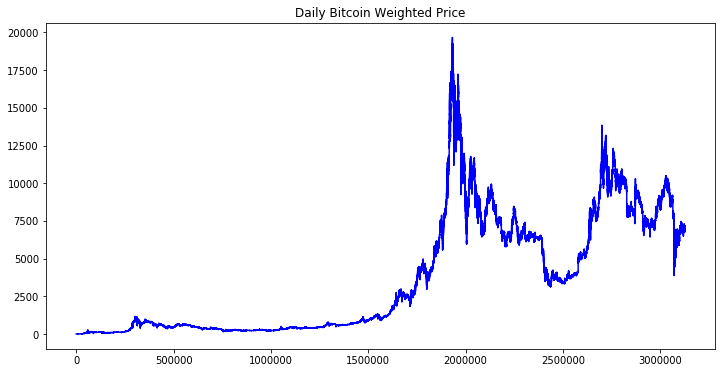

In [47]:
#display the data
plt.figure(figsize=(12,6))
daily_price.plot(title='Daily Bitcoin Weighted Price', color='blue')
plt.show()


In [48]:
group = data.groupby('date')
Daily_Price_mean = group['Weighted_Price'].mean()
Daily_Price_mean = Daily_Price_mean.dropna()

In [49]:
def make_time_series(mean_power_df, years, freq='D', start_idx=0):
    '''Creates as many time series as there are complete years. This code
       accounts for the leap year, 2016.
      :param Daily_Price_mean: A dataframe of bitcoin weighted price, averaged by day.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2013', '2014'].
      :param freq: The frequency of data recording (D = daily)
      :param start_idx: The starting dataframe index of the first point in the first time series.
          The default, 16, points to '2013-01-01'. 
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # store leap year in this dataset
    leap = '2012'

    # create time series for each year in years
    for i in range(len(years)):

        year = years[i]
        if(year == leap):
            end_idx = start_idx+366
        else:
            end_idx = start_idx+365

        # create start and end datetimes
        t_start = year + '-01-01' # Jan 1st of each year = t_start
        t_end = year + '-12-31' # Dec 31st = t_end

        # get global consumption data
        data = mean_power_df[start_idx:end_idx]

        # create time series for the year
        index = pd.date_range(start=t_start, end=t_end, freq=freq)
        
        time_series.append(pd.Series(data=data, index=index))
        
        start_idx = end_idx
    
    # return list of time series
    return time_series
    

In [50]:
full_years = ['2012', '2013', '2014']
freq='D' # daily recordings

# make time series
time_series = make_time_series(Daily_Price_mean, full_years, freq=freq)

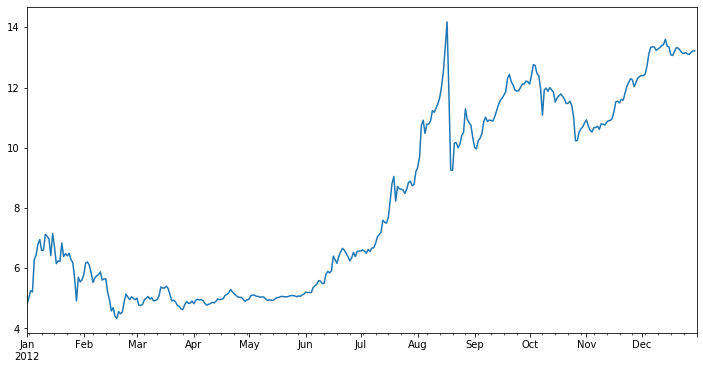

In [51]:
# display first time series
time_series_idx = 0

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot()
plt.show()

Here, we want to predict about a month's worth of data, and we'll set prediction_length to 30 (days).
To create a training set of data, we'll leave out the last 30 points of each of the time series we just generated, so we'll use only the first part as training data.
The test set contains the complete range of each time series.

In [52]:
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        # truncate trailing 30 pts
        time_series_training.append(ts[:-prediction_length])
        
    return time_series_training

In [53]:
# set prediction length
prediction_length = 30 # 30 days ~ a month

time_series_training = create_training_series(time_series, prediction_length)
print('****Time Series Triaing data****')
print(time_series_training)
print('****Time series data***')
print(time_series)

****Time Series Triaing data****
[2012-01-01     4.806667
2012-01-02     5.000000
2012-01-03     5.252500
2012-01-04     5.208159
2012-01-05     6.284127
                ...    
2012-11-27    12.027735
2012-11-28    12.174469
2012-11-29    12.318352
2012-11-30    12.367808
2012-12-01    12.400915
Freq: D, Name: Weighted_Price, Length: 336, dtype: float64, 2013-01-01      13.073099
2013-01-02      13.121748
2013-01-03      13.147362
2013-01-04      13.154518
2013-01-05      13.139496
                 ...     
2013-11-27     926.175452
2013-11-28     990.586974
2013-11-29    1059.801836
2013-11-30    1137.763090
2013-12-01    1017.485922
Freq: D, Name: Weighted_Price, Length: 335, dtype: float64, 2014-01-01    745.302284
2014-01-02    757.829339
2014-01-03    796.724760
2014-01-04    811.281011
2014-01-05    867.830795
                 ...    
2014-11-27    371.112227
2014-11-28    369.611490
2014-11-29    378.062896
2014-11-30    376.679235
2014-12-01    378.411245
Freq: D, Name: Weight

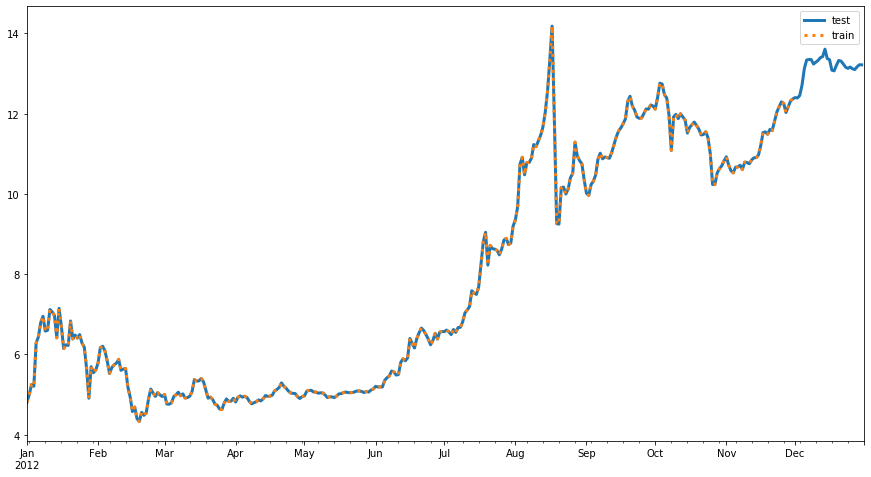

In [54]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

Since I first want to test/model out the DeepAR RNN network that AWS Sagemaker has, we will convert the test data into JSON because DeepAR requires that

In [83]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj

In [84]:
# test out the code
ts = time_series[0]

json_obj = series_to_json_obj(ts)

tst = time_series_training[0]

json_objt = series_to_json_obj(tst)

print(json_obj.keys())
print(json_objt.keys())

dict_keys(['start', 'target'])
dict_keys(['start', 'target'])


In [85]:
import s3fs
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(train_path, 'rb') as fp:
#     print(fp.readline().decode("utf-8")[:100] + "...")
    print(fp.readline().decode("utf-8"))
    print(fp.readline())

{"start": "2012-01-01 00:00:00", "target": [4.806666666666667, 5.0, 5.2525, 5.208159313655556, 6.2841271510761905, 6.438999047607142, 6.8, 6.95, 6.582769666666665, 6.602999999999999, 7.120684842337494, 7.062499999999999, 6.9692365244187515, 6.414081197579999, 7.15, 6.714285714285715, 6.1483461580375005, 6.240688438936111, 6.225714285714285, 6.834999999999999, 6.386, 6.485, 6.4075, 6.495555555555554, 6.2836637977861125, 6.184091794074999, 5.65142857142857, 4.91, 5.696, 5.544999999999999, 5.6140454556560995, 5.784578347825, 6.170195246214032, 6.205149061870368, 6.0954747419625, 5.839202668429167, 5.52625, 5.672000000000001, 5.742069750966667, 5.7835714285714275, 5.876923076923076, 5.605, 5.637499999999999, 5.648181818181818, 5.19323665560303, 4.945263157894737, 4.577144055188235, 4.690011362803124, 4.398910980869231, 4.331666666666666, 4.557995986628573, 4.484217150443752, 4.542749342733334, 4.889657323899999, 5.138749626680001, 5.038870406285715, 4.954744525542858, 5.049619004523076, 4.

In [89]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(json_obj, filename): 
    with open(filename, 'wb') as f:
        json_line = json_line = "\"start\":\"{}\",\"target\":{}".format(json_obj['start'], json_obj['target'])
        json_line = json_line.encode('utf-8')
        f.write(json_line)
    print(filename + ' saved.')

    #def write_json_dataset(json_obj, filename): 
    #with open(filename, 'w') as f:
        #keys = json_obj.keys()
        #print(keys)
       # json_line = "\"start\":\"{}\",\"target\":{}".format(json_obj['start'], json_obj['target'])
       # json_line = json_line.encode('utf-8')
        #f.write('{'+json_line+'}\n')
   # print(filename+'saved.')
      

In [90]:
# save this data to a local directory
data_dir = 'json_bitcoin_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [91]:
# directories to save train/test data

train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
#write_json_dataset(time_series_training, train_key)        
#write_json_dataset(time_series, test_key)
write_json_dataset(json_objt, train_key)        
write_json_dataset(json_obj, test_key)

json_bitcoin_data/train.json saved.
json_bitcoin_data/test.json saved.


Uploading Data to S3
Next, to make this data accessible to an estimator, I'll upload it to S3.

In [92]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [93]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()

In [94]:
# general prefix
prefix='deepar-bitcoin'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [95]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-2-729848575777/deepar-bitcoin/train/train.json
Test data is stored in: s3://sagemaker-us-east-2-729848575777/deepar-bitcoin/test/test.json


TRAIN THE DEEPAR ESTIMATOR

In [96]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

In [97]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

In [98]:
freq='D'
context_length=30 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [99]:
estimator.set_hyperparameters(**hyperparameters)

NOW WE WILL TRAIN THE JOB

In [100]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-07-24 02:15:21 Starting - Starting the training job...
2020-07-24 02:15:22 Starting - Launching requested ML instances.........
2020-07-24 02:16:54 Starting - Preparing the instances for training......
2020-07-24 02:17:58 Downloading - Downloading input data...
2020-07-24 02:18:47 Training - Downloading the training image..Arguments: train
[07/24/2020 02:19:02 INFO 140489411778368] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[07/24/2020 02:1

UnexpectedStatusException: Error for Training job forecasting-deepar-2020-07-24-02-15-20-975: Failed. Reason: ClientError: Error when parsing json (source: /opt/ml/input/data/train/train.json, row: 1)

DEPLOY AND CREATE A PREDICTOR

In [ ]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)